In [ ]:
!pip install crcmod
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

!gsutil -m -o 'GSUtil:parallel_composite_upload_threshold_1M''GSUtil:sliced_object_download_max_components=8' cp -r gs://evenergy163.appspot.com/data/** .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp311-cp311-linux_x86_64.whl size=31659 sha256=d8345d150d3a3c0de8a16f025ffe885e83de65e6b704f277bd6a36b6d1972063
  Stored in directory: /root/.cache/pip/wheels/23/94/7a/8cb7d14597e6395ce969933f01aed9ea8fa5f5b4d4c8a61e99
Successfully built crcmod
Copying gs://evenergy163.appspot.com/data/evwatts.public.evse.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.connector.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.session.csv...
Copying gs://evenergy163.appspot.com/data/Monthly Gas Prices.csv...
Copying gs://evenergy163.appspot.com/data/California Electric Rates.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.dictionary.txt...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehicletrips.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehicles.csv...
Cop

In [ ]:
session_data = pd.read_csv('evwatts.public.session.csv')
evse_data = pd.read_csv('evwatts.public.evse.csv')
merged_data = pd.merge(session_data, evse_data[['evse_id', 'charge_level', 'region', 'metro_area']], on='evse_id', how='left')
session_data = merged_data

session_data['start_datetime'] = pd.to_datetime(session_data['start_datetime'])
session_data['year_month'] = session_data['start_datetime'].dt.to_period('M')
session_data.head(5)

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,charge_level,region,metro_area,year_month
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,L2,Middle Atlantic,Undesignated,2020-03
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212,NaN,NaN,0,L2,Middle Atlantic,Undesignated,2020-03
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,L2,Middle Atlantic,"Rochester, NY Metro Area",2020-03
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",2020-03
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",2020-02


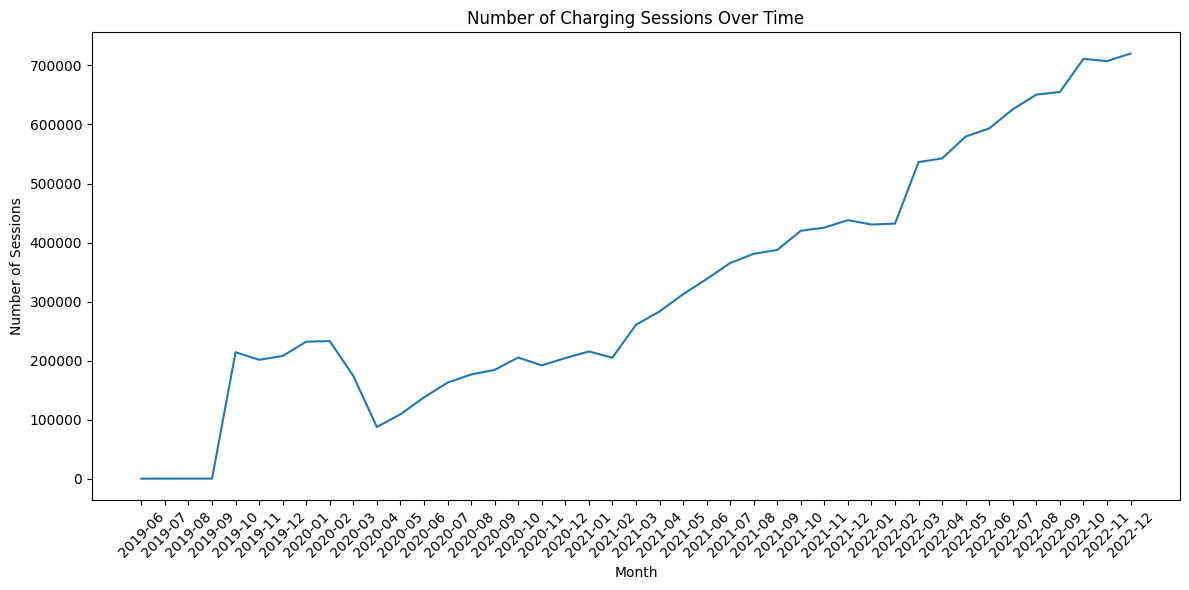

In [ ]:
session_data['year_month'] = session_data['start_datetime'].dt.to_period('M')

monthly_sessions = session_data.groupby('year_month')['session_id'].count().reset_index()
monthly_sessions['year_month'] = monthly_sessions['year_month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sessions, x='year_month', y='session_id')
plt.title('Number of Charging Sessions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Average monthly sessions: 324121.74
Approx. monthly growth rate: 15818.99 sessions/month
Monthly percentage growth: 4.88%
R-squared: 0.9017


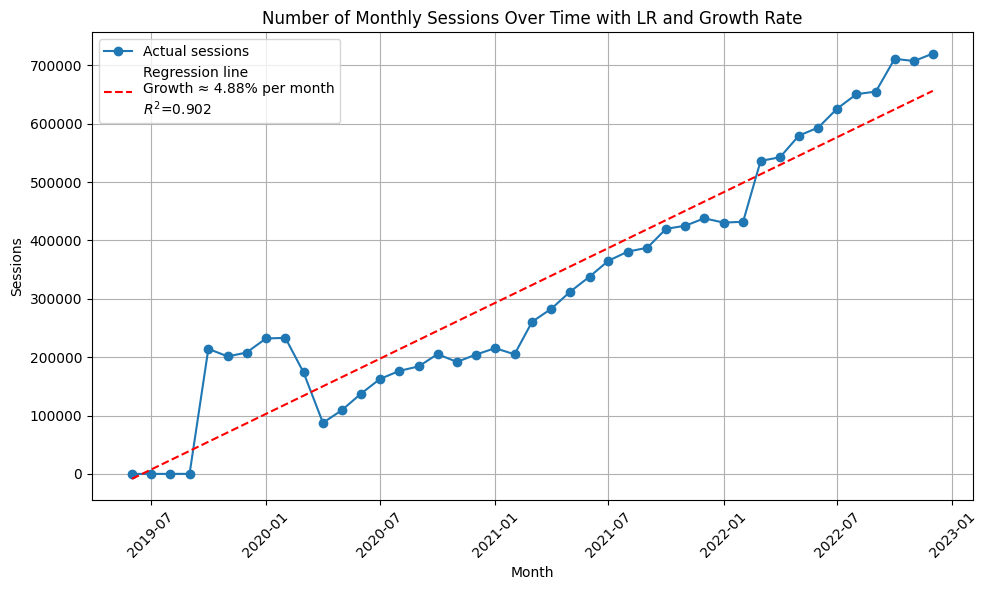

In [ ]:
#monthly_sessions

monthly_sessions['year_month'] = pd.to_datetime(monthly_sessions['year_month'])

# Numeric conversion (days as ordinals)
x_numeric = monthly_sessions['year_month'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = monthly_sessions['session_id'].values

# Fit regression model
model = LinearRegression().fit(x_numeric, y)

# Daily growth (from regression slope)
daily_growth = model.coef_[0]

# Monthly growth (approx. days per month)
monthly_growth = daily_growth * 30.44

# Monthly percentage growth calculation
average_monthly_sessions = y.mean()
monthly_percentage_growth = (monthly_growth / average_monthly_sessions) * 100

# R-squared value
r_squared = model.score(x_numeric, y)

# Display clearly
print(f"Average monthly sessions: {average_monthly_sessions:.2f}")
print(f"Approx. monthly growth rate: {monthly_growth:.2f} sessions/month")
print(f"Monthly percentage growth: {monthly_percentage_growth:.2f}%")
print(f"R-squared: {r_squared:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_sessions['year_month'], y, 'o-', label='Actual sessions')
plt.plot(monthly_sessions['year_month'], model.predict(x_numeric), 'r--',
         label=f'Regression line\nGrowth ≈ {monthly_percentage_growth:.2f}% per month\n$R^2$={r_squared:.3f}')

plt.xlabel('Month')
plt.ylabel('Sessions')
plt.title('Number of Monthly Sessions Over Time with LR and Growth Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Analysis of Session over time
Using linear regression, we see that the number of monthly session is trending upward, meaning growth. We have a r2 score of 0.902 meaning it fitted pretty well, and found the growth rate to be approximately 4.88% per month.

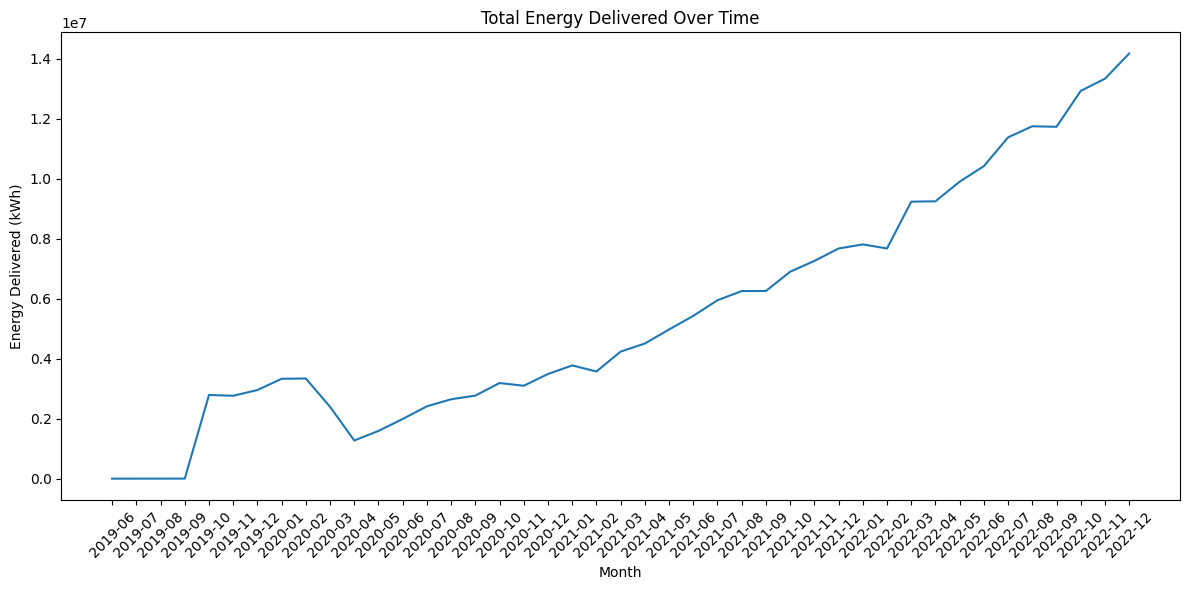

In [ ]:
monthly_energy = session_data.groupby('year_month')['energy_kwh'].sum().reset_index()
monthly_energy['year_month'] = monthly_energy['year_month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_energy, x='year_month', y='energy_kwh')
plt.title('Total Energy Delivered Over Time')
plt.xlabel('Month')
plt.ylabel('Energy Delivered (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Average monthly energy: 5499040.90
Approx. monthly growth rate: 299536.67 energy/month
Monthly percentage growth: 5.45%
R-squared: 0.9085


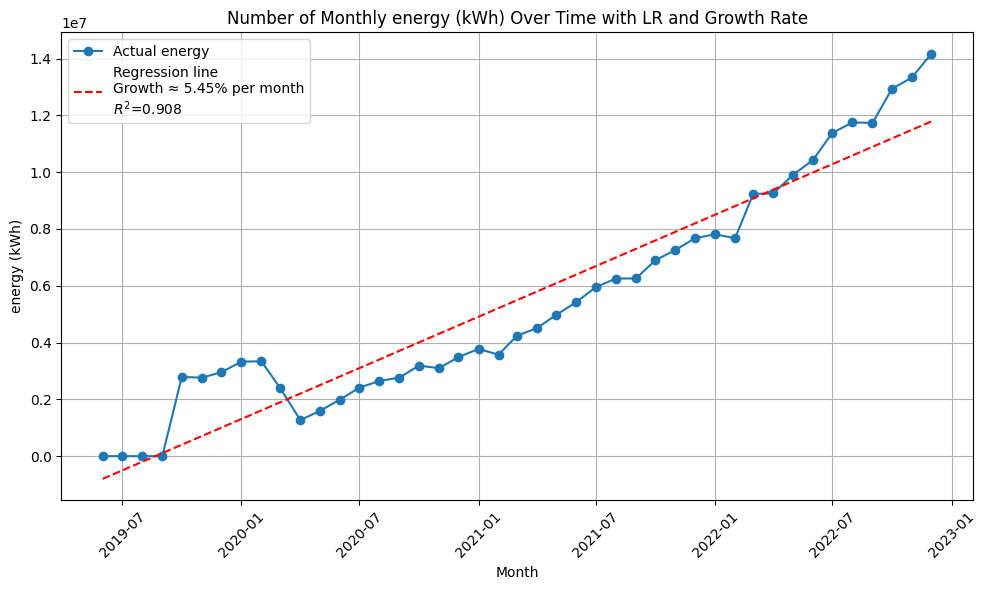

In [ ]:
monthly_energy['year_month'] = pd.to_datetime(monthly_energy['year_month'])

# Numeric conversion (days as ordinals)
x_numeric = monthly_energy['year_month'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = monthly_energy['energy_kwh'].values

# Fit regression model
model = LinearRegression().fit(x_numeric, y)

# Daily growth (from regression slope)
daily_growth = model.coef_[0]

# Monthly growth (approx. days per month)
monthly_growth = daily_growth * 30.44

# Monthly percentage growth calculation
average_monthly_energy = y.mean()
monthly_percentage_growth = (monthly_growth / average_monthly_energy) * 100

# R-squared value
r_squared = model.score(x_numeric, y)

# Display clearly
print(f"Average monthly energy: {average_monthly_energy:.2f}")
print(f"Approx. monthly growth rate: {monthly_growth:.2f} energy/month")
print(f"Monthly percentage growth: {monthly_percentage_growth:.2f}%")
print(f"R-squared: {r_squared:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_energy['year_month'], y, 'o-', label='Actual energy')
plt.plot(monthly_energy['year_month'], model.predict(x_numeric), 'r--',
         label=f'Regression line\nGrowth ≈ {monthly_percentage_growth:.2f}% per month\n$R^2$={r_squared:.3f}')

plt.xlabel('Month')
plt.ylabel('energy (kWh)')
plt.title('Number of Monthly energy (kWh) Over Time with LR and Growth Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Shape is almost identical to Plot 1.
Linear regression fitted well with a r2 score of 0.908, and has an monthly growth rate of 5.45%

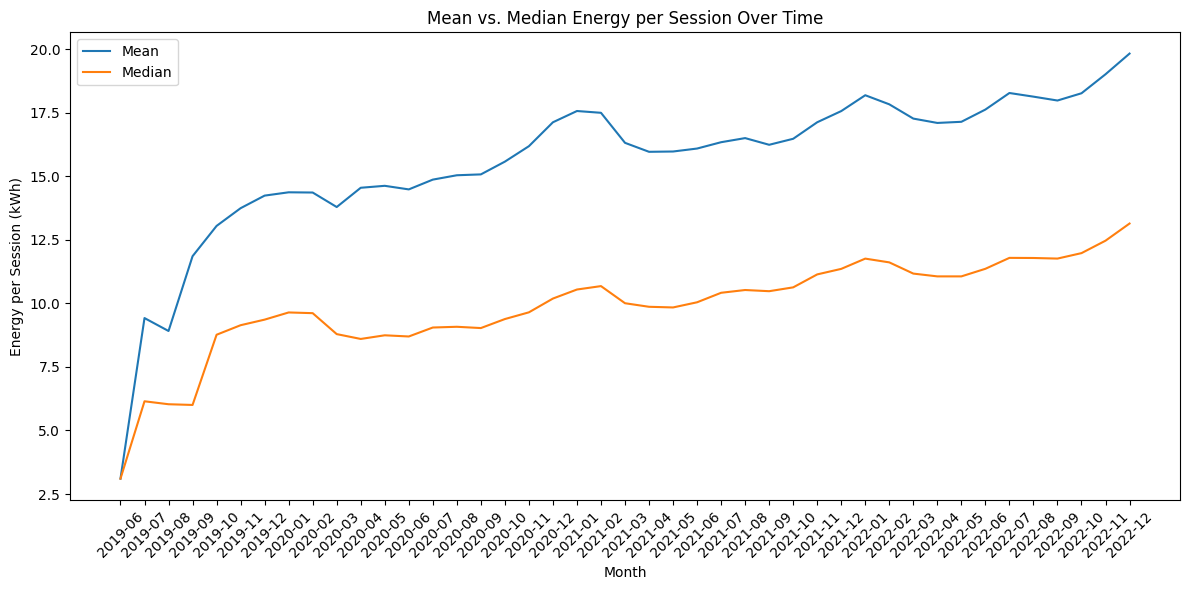

In [ ]:
median_energy_per_session = session_data.groupby('year_month')['energy_kwh'].median().reset_index(name='median_energy_per_session')
mean_df = session_data.groupby('year_month')['energy_kwh'].mean().reset_index(name='mean_energy')
median_df = session_data.groupby('year_month')['energy_kwh'].median().reset_index(name='median_energy')

# Merge
combined = pd.merge(mean_df, median_df, on='year_month')
combined['year_month'] = combined['year_month'].astype(str)

# Plot both
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined, x='year_month', y='mean_energy', label='Mean')
sns.lineplot(data=combined, x='year_month', y='median_energy', label='Median')
plt.title('Mean vs. Median Energy per Session Over Time')
plt.xlabel('Month')
plt.ylabel('Energy per Session (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Linear Regression R²: 0.7598
Linear Monthly Growth Rate: 1.33% per month

Exponential Regression R²: 0.7100
Exponential Monthly Growth Rate: 1.54% per month



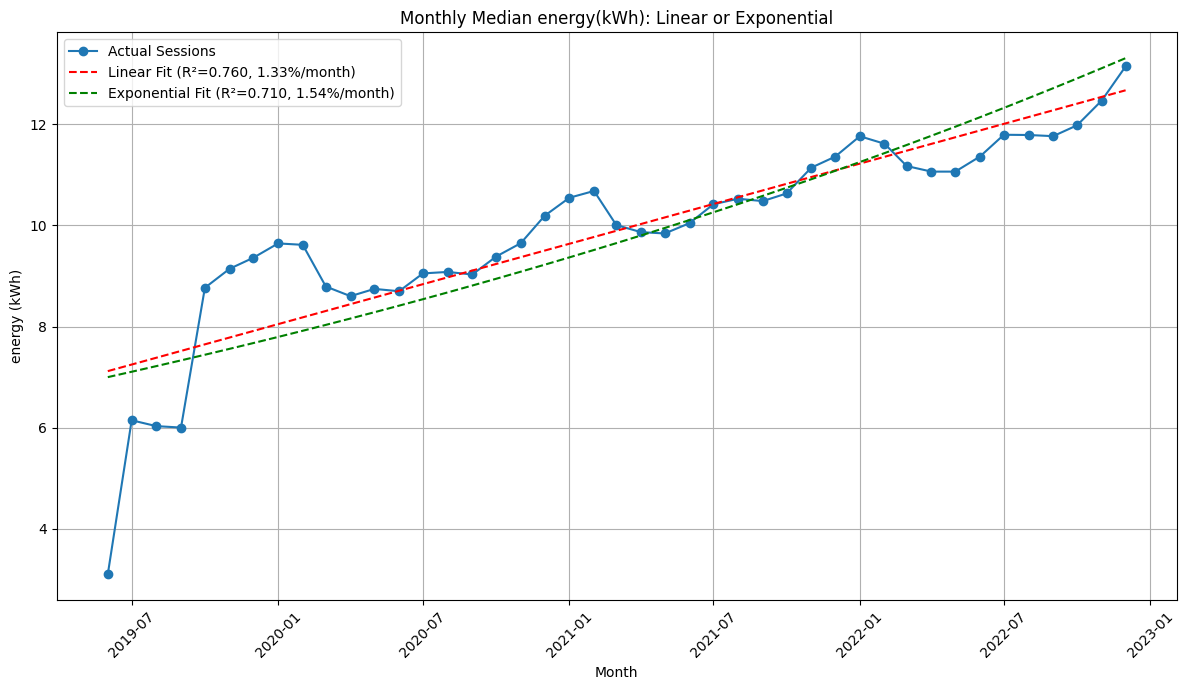

In [ ]:
combined['year_month'] = pd.to_datetime(combined['year_month'])
x_numeric = combined['year_month'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = combined['median_energy'].values

# Linear Regression
linear_model = LinearRegression().fit(x_numeric, y)
y_linear_pred = linear_model.predict(x_numeric)
linear_r2 = linear_model.score(x_numeric, y)

# Calculate linear monthly growth percentage
daily_growth = linear_model.coef_[0]
monthly_growth = daily_growth * 30.44
monthly_percentage_growth_linear = (monthly_growth / y.mean()) * 100

# Exponential Regression
# Fit linear regression to log(y)
log_y = np.log(y)
exp_model = LinearRegression().fit(x_numeric, log_y)
log_y_pred = exp_model.predict(x_numeric)
y_exp_pred = np.exp(log_y_pred)

# Calculate R-squared for exponential fit
exp_r2 = r2_score(y, y_exp_pred)

# Monthly exponential growth rate (%)
daily_exp_growth_rate = exp_model.coef_[0]
monthly_exp_growth_rate = (np.exp(daily_exp_growth_rate * 30.44) - 1) * 100

# Print results clearly
print(f"Linear Regression R²: {linear_r2:.4f}")
print(f"Linear Monthly Growth Rate: {monthly_percentage_growth_linear:.2f}% per month\n")

print(f"Exponential Regression R²: {exp_r2:.4f}")
print(f"Exponential Monthly Growth Rate: {monthly_exp_growth_rate:.2f}% per month\n")

# Plot clearly
plt.figure(figsize=(12, 7))

# Actual data
plt.plot(combined['year_month'], y, 'o-', label='Actual Sessions')

# Linear regression
plt.plot(combined['year_month'], y_linear_pred, 'r--',
         label=f'Linear Fit (R²={linear_r2:.3f}, {monthly_percentage_growth_linear:.2f}%/month)')

# Exponential regression
plt.plot(combined['year_month'], y_exp_pred, 'g--',
         label=f'Exponential Fit (R²={exp_r2:.3f}, {monthly_exp_growth_rate:.2f}%/month)')

plt.xlabel('Month')
plt.ylabel('energy (kWh)')
plt.title('Monthly Median energy(kWh): Linear or Exponential')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Analysis of median_energy usage
Here we found that the linear regression model is the better fit with a r2 score of 0.760 compared to the exponential fit of 0.710. We also found that the median energy usage grows by 1.33% per month

EV charging sessions in the U.S. have followed a strong and consistent linear growth pattern. While usage is increasing month over month, the trend does not reflect exponential acceleration. This highlights the importance of ongoing but steady investment in charging infrastructure, energy capacity, and grid readiness — not crisis-level exponential scaling.”